# Coursera Applied Data Science Capstone
## Comparison of Large Cities to Determine Olympic Host Worthiness from Dining/Entertainment Venue Data

This work is intended to compare venue data to determine if we can classify a city as Olympic worthy or not. This is in contrast to the usual host criteria such as sufficient lodging, efficient traffic, and enough security. Essentially, this work will determine if a city can support Olympic visitors when it comes to dining and things to do outside of the main event.

In [1]:
# Import data libraries
import pandas as pd
import numpy as np
import re
import time # Required to sleep while looping through cities to prevent Foursquare API hourly limit
# Import mapping library
import geopy
import geocoder
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from tqdm import tqdm
import folium
import requests
# Import Plotting Libraries
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib import rc
# import k-means from clustering stage
from sklearn.cluster import KMeans

## Step 1: Gathering Data

First thing to do to collect and process the data. We'll need a few bits of data:

    1. City population data
    2. Geolocations of those cities
    3. Whether these cities hosted the Olympics or not. And if so, when.
    4. Venue data for these cities

### Olympic Hosts

We'll first gather the list of Olympic hosts. Since there are only so many host cities, we'll also consider any cities that have made it to the final stages of the bidding process but didn't get selected. We will obtain our data from [Wikipedia](https://www.wikiwand.com/en/Bids_for_Olympic_Games).

In [2]:
# from bs4 import BeautifulSoup
# import requests
# # Load wiki page
# url = 'https://en.wikipedia.org/w/index.php?title=Bids_for_Olympic_Games&oldid=948466122'
# source = requests.get(url).text
# soup = BeautifulSoup(source,'lxml')
# bids_dict = {'City':[],
#              'Country':[],
#              'Winter':[], # Highest position in bidding process for Winter (1 = finals, 2 = hosted)
#              'Summer':[], 
#              'Year':[],   # Most recent year
#              }
# # Get two tables
# tables = soup.findAll('table')
# bidTables = []
# for table in tables:
#     ths = table.find_all('th')
#     headings = [th.text.strip() for th in ths]
#     if headings[:4] == ['Country', 'City', 'Bids','Host']:
#         bidTables.append( table )
# # Process each table
# prevCountry = ''
# for season, table in enumerate(bidTables):
#     for tr in table.find_all('tr'):
#         tds=tr.find_all('td')
#         if(not tds):
#             continue
#         # print([td.text.strip() for td in tds])
#         if(len(tds) == 4):
#             country, city, bids, host = [td.text.strip() for td in tds]
#         else:
#             country = prevCountry
#             city, bids, host = [td.text.strip() for td in tds]
#         mostRecentBid = max([int(year) for year in bids.replace(' ', '').rstrip().replace('(',',').replace(')','').split(',')[1:]])
#         if(host != ''):
#             summer = 2 if season == 0 else 0
#             winter = 2 if season == 1 else 0
#             mostRecentHost = max([int(year) for year in host.replace(' ', '').rstrip().replace('(',',').replace(')','').split(',')[1:]])
#         else:
#             summer = 1 if season == 0 else 0
#             winter = 1 if season == 1 else 0
#             mostRecentHost = 0
#         prevCountry = country
#         bids_dict['Country'].append(country)
#         bids_dict['City'].append(city)
#         bids_dict['Year'].append(max(mostRecentBid,mostRecentHost))
#         bids_dict['Summer'].append(summer)
#         bids_dict['Winter'].append(winter)
# df_hosts = pd.DataFrame(bids_dict)
# # Save data to reuse or manually alter
# # df_hosts.to_csv('OlympicBids.csv', index=False)

In [2]:
# Load previously saved data
df_hosts = pd.read_csv('OlympicBids.csv')
# Consider only years > 1990
df_hosts = df_hosts[df_hosts['Year']>1990]



### List of Large Cities

The United Nations Statistics Division maintains worldwide census data. The most recent one available is from [2018](https://unstats.un.org/unsd/demographic-social/products/dyb/dyb_2018/). The table we want is Table 8, which contains general population data for cities with population, $P>100,000$. There are several thousand cities that satisfy that criteria, so we'll increase the cutoff to $P>1,000,000$ (Chosen to keep number of cities to explore to a reasonable time). We'll manually insert any Olympic host cities that fall beneath that cutoff. In the case where values are given for both the city proper and the urban conglomeration, we'll take the larger of the two.

The datafile isn't the best format for importing into Pandas so it needs to be cleaned first. The raw data is formatted as follows:

    1. Header is on row 5
    2. Countries are grouped by continent in alphabetical order. Continent groups are preceded by a blank line, first one included.
    3. Countries are listed with an indent. This is an excel formatting option and not the usual tab character or space.
    4. Following each country is a row indicating the date the data for that particular country was obtained.
    5. Then each city is given per row, with columns indicating populations. CAPITALIZED cities are capitals.
    6. There are also blank columns between each data column.
    7. Some cells also have superscripts, indicating footnotes.

This is not something that is easy nor simple to do programmatically in Python due to #2 which requires VBA to process. During this processing, I've also manually changed some nations' official names to their more common names (i.e. Republic of Korea -> South Korea). Even with the cleaning, we'll still have to write our own import function.

NOTE: Other than Beijing, other Chinese cities were not present in the data. We could find another source to merge with this but we'll ignore this for now.

In [3]:
POPULATION_CUTOFF = 1000000

In [16]:
with open('United_Nations_Population_Data_Cleaned.csv','r') as file:
    data = {
        'Country':[],
        'City':[],
        'Capital':[],
        'Population_City':[],
        'Population_Urban':[]
    }
    file.readline() # Skips header row
    currentCountry = ''
    for line in file.readlines():
        row = line.strip().split(',')
        # print(int(row[1]))
        # x = x+1
        if(int(row[1]) == 0):
            currentCountry = row[0]
            # print(currentCountry)
            continue
        else:
            data['Country'].append(currentCountry)
            data['City'].append(row[0].lower().title())
            data['Capital'].append(row[2])
            data['Population_City'].append(row[3])
            data['Population_Urban'].append(row[4])
df_cities = pd.pandas.DataFrame.from_dict(data).astype({'Capital':'int','Population_City':'int32','Population_Urban':'int32'})
df_cities.head()

,Country,City,Capital,Population_City,Population_Urban
0,Algeria,Adrar,0,200834,0
1,Algeria,Ain Defla,0,450280,0
2,Algeria,Ain Temouchent,0,299341,0
3,Algeria,Algiers,1,2712944,0
4,Algeria,Annaba,0,442230,0


In [17]:
df_cities['Population']=df_cities[['Population_City','Population_Urban']].max(axis=1)
df_cities.drop(columns=['Population_City','Population_Urban'],inplace=True)
df_cities = pd.merge(df_cities,df_hosts, how='outer',on=['Country','City'])

In [18]:
df_cities = df_cities.groupby(['Country','City']).max().reset_index()
df_large_cities = df_cities[((df_cities['Population']>POPULATION_CUTOFF) | (df_cities['Year']>0))]
df_large_cities = df_large_cities.groupby(['Country','City']).max().reset_index()
df_large_cities.replace(np.nan,0,inplace=True)

In [19]:
df_large_cities=df_large_cities.astype({'Capital':'int','Population':'int32','Winter':'int','Summer':'int','Year':'int'})
df_large_cities.head()

,Country,City,Capital,Population,Winter,Summer,Year
0,Afghanistan,Kabul,1,3817241,0,0,0
1,Algeria,Algiers,1,2712944,0,0,0
2,Algeria,Wahran,0,1165687,0,0,0
3,Andorra,Andorra La Vella,1,22205,1,0,2010
4,Angola,Luanda,1,2487444,0,0,0


With a cutoff of $1,000,000$ and including Olympic hopefuls under the threshold, we were able to limit our search down to 338 cities with 132 of them having bid for the Olympics (either Summer or Winter).

### Location Data

Now we want to get the latitude and longitude of each city so that we can use that to search for venues in Foursquare

We use Nominatim as our geolocator. It has a rate limit of $1$ search per second so this will take $\approx 2$ minutes.

In [20]:
geolocator = Nominatim(user_agent='city_locator')
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

In [21]:
tqdm.pandas()
df_large_cities['Location']=(df_large_cities['City'] + ', ' + df_large_cities['Country']).progress_apply(geocode)
df_large_cities['Latitude'] = df_large_cities['Location'].apply(lambda loc: tuple(loc.point)[0] if loc else None)
df_large_cities['Longitude'] = df_large_cities['Location'].apply(lambda loc: tuple(loc.point)[1] if loc else None)

100%|██████████| 388/388 [08:35<00:00,  1.33s/it]


In [22]:
df_large_cities.head()

,Country,City,Capital,Population,Winter,Summer,Year,Location,Latitude,Longitude
0,Afghanistan,Kabul,1,3817241,0,0,0,"(کابل, كابل, 10013, Afghanistan, (34.5260131, ...",34.526013,69.177648
1,Algeria,Algiers,1,2712944,0,0,0,"(Algiers, Sidi M'Hamed, Alger, 16007, الجزائر,...",36.775361,3.060188
2,Algeria,Wahran,0,1165687,0,0,0,"(Wahrān, الطريق السيار شرق-غرب, Oggaz عقاز, da...",35.542819,-0.342180
3,Andorra,Andorra La Vella,1,22205,1,0,2010,"(Andorra la Vella, AD500, Andorra, (42.5069391...",42.506939,1.521247
4,Angola,Luanda,1,2487444,0,0,0,"(Luanda, Angola, (-8.8272699, 13.2439512))",-8.827270,13.243951


In [10]:
# df_large_cities.drop(columns='Location',inplace=True)
df_large_cities.dropna(subset=['Latitude'],inplace=True)
# Save processed location data just in case
df_large_cities.to_csv('Location_Data.csv',index=False)

In [2]:
# Read data previously saved so you don't have to go through process again
df_large_cities = pd.read_csv('Location_Data.csv')
df_large_cities.head()

,Country,City,Capital,Population,Winter,Summer,Year,Latitude,Longitude
0,Afghanistan,Kabul,1,3817241,0,0,0,34.526013,69.177648
1,Algeria,Algiers,1,2712944,0,0,0,36.775361,3.060188
2,Algeria,Wahran,0,1165687,0,0,0,35.542819,-0.342180
3,Andorra,Andorra La Vella,1,22205,1,0,2010,42.506939,1.521247
4,Angola,Luanda,1,2487444,0,0,0,-8.827270,13.243951


In [3]:
# Map of world
world_map = folium.Map()

colors = ['#ff878c','#e50000','#A0A0A0','#75bbfd','#0504aa'] # lightred, red, gray, lightblue, blue
icons = ['circle', 'star']
for lat, lng, country, city, winter, summer in zip(df_large_cities['Latitude'],df_large_cities['Longitude'],df_large_cities['Country'],df_large_cities['City'],df_large_cities['Winter'],df_large_cities['Summer']):
    label = f"{city}, {country}"
    color = colors[summer-1 if (summer > 0) else winter+2]
    folium.CircleMarker([lat,lng],
        popup=label,
        radius = 2,
        color = color,
    ).add_to(world_map)
world_map

The world map shows the locations of each of our cities. Red cities are Summer Olympic cities and blue are for the Winter Olympics. The darker shade of each color indicate that the city has hosted at some point while the normal shade indicates that the city has been through the selection process but never selected.

### Venue Data
With the location data for each city, we can now iterate through them to find all the dining and entertainment venues using the Foursquare API.

In [5]:
# API Credentials
CLIENT_ID = '2FY41QWJDJIXPBTEL0JXJCXHBFUL0VIAY5IFL4RQ0O4B1CXO'
CLIENT_SECRET = 'DRE3VWEOWVT2PQ1AZI2RDAE4NR3UK0AWAYCLNN32WXNDKOMM'
VERSION = '20180605' # Foursquare API version

categoryIds = {'Arts And Entertainment':'4d4b7104d754a06370d81259',
                                 'Food':'4d4b7105d754a06374d81259',
                            'Education':'4d4b7105d754a06372d81259',
                                'Event':'4d4b7105d754a06373d81259',
                            'Nightlife':'4d4b7105d754a06376d81259',
              'Outdoors And Recreation':'4d4b7105d754a06377d81259',
                         'Professional':'4d4b7105d754a06375d81259',
                     'Shop And Service':'4d4b7105d754a06378d81259',
                               'Travel':'4d4b7105d754a06379d81259'
               }
RADIUS = 30000
LIMIT = 50

In [96]:
def getVenues(country, city, lat, lng, categoryName):
    df_venues_total = pd.DataFrame(columns=['Country','City','Venue Category','Venue Name'])
    api_calls = 0
    currentSize = df_venues_total.shape[0]
    while(api_calls < 100):
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&offset={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET,
            VERSION,
            lat, 
            lng, 
            RADIUS,
            LIMIT,
            LIMIT*api_calls,
            categoryIds[categoryName])
        try:
            results = requests.get(url).json()["response"]['groups'][0]['items']
        except:
            break
        api_calls += 1
        if(len(results) == 0):
            # print('breaking due to end of search')
            break
        venues_list=[]
        venues_list.append([(
            country,
            city,
            categoryName,
            v['venue']['name'] 
            ) for v in results])
        nearby_venues_page = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        nearby_venues_page.columns = ['Country','City','Venue Category','Venue Name']
        df_venues_total=df_venues_total.append(nearby_venues_page,ignore_index=True)
        df_venues_total.drop_duplicates(inplace=True)
        if(df_venues_total.shape[0] == currentSize):
            # print('breaking due to no new locations')
            break
        else:
            currentSize=df_venues_total.shape[0]
    return df_venues_total, api_calls

In [97]:
df_venues = pd.DataFrame(columns=['Country','City','Venue Category','Venue Name'])
api_calls_total = 0
for country, city, lat, lng in zip(df_large_cities['Country'],df_large_cities['City'],df_large_cities['Latitude'],df_large_cities['Longitude']):
    print(f"{city}, {country} / ", end = " ")

    temp, calls = getVenues(country, city, lat, lng, 'Arts And Entertainment')
    df_venues = df_venues.append(temp,ignore_index=True)
    api_calls_total += calls
    print(" Entertainment ", end = " ")

    temp, calls = getVenues(country, city, lat, lng, 'Food')
    df_venues = df_venues.append(temp,ignore_index=True)
    api_calls_total += calls
    print(" Food ", end = " ")

    temp, calls = getVenues(country, city, lat, lng, 'Nightlife')
    df_venues = df_venues.append(temp,ignore_index=True)
    api_calls_total += calls
    print(" Nightlife ", end = " ")

    temp, calls = getVenues(country, city, lat, lng, 'Outdoors And Recreation')
    df_venues = df_venues.append(temp,ignore_index=True)
    api_calls_total += calls
    print(" Outdoors / ", end = " ")
    print(" Calls so far: ", api_calls_total)

    if(api_calls_total > 4000):
        print( " Hourly limit approaching!!! Sleeping for an hour. ")
        time.sleep(3600) # If we get close to hourly limit, wait an hour.
        api_calls_total = 0


Kabul, Afghanistan / Entertainment Food Nightlife Outdoors /   Calls so far:  8
Algiers, Algeria / Entertainment Food Nightlife Outdoors /   Calls so far:  17
Wahran, Algeria / Entertainment Food Nightlife Outdoors /   Calls so far:  25
Andorra La Vella, Andorra / Entertainment Food Nightlife Outdoors /   Calls so far:  38
Luanda, Angola / Entertainment Food Nightlife Outdoors /   Calls so far:  47
Buenos Aires, Argentina / Entertainment Food Nightlife Outdoors /   Calls so far:  72
Córdoba, Argentina / Entertainment Food Nightlife Outdoors /   Calls so far:  85
Mendoza, Argentina / Entertainment Food Nightlife Outdoors /   Calls so far:  93
Rosario, Argentina / Entertainment Food Nightlife Outdoors /   Calls so far:  103
Yerevan, Armenia / Entertainment Food Nightlife Outdoors /   Calls so far:  114
Adelaide, Australia / Entertainment Food Nightlife Outdoors /   Calls so far:  130
Brisbane, Australia / Entertainment Food Nightlife Outdoors /   Calls so far:  150
Melbourne, Australia /

In [98]:
# Save data since it took a long time to collect
df_venues.to_csv('venue_data.csv',index=False)

In [6]:
df_venues = pd.read_csv('venue_data.csv')

In [7]:
venue_counts = df_venues.groupby(['Country','City','Venue Category']).count()
venue_counts.rename(columns={'Venue Name':'Counts'},inplace=True)
venue_counts = venue_counts.unstack(2).reset_index()
venue_counts.replace(np.nan, 0, inplace=True)
venue_counts.columns = ['Country', 'City', 'Arts And Entertainment', 'Food', 'Nightlife',
       'Outdoors And Recreation']
venue_counts=venue_counts.astype({'Arts And Entertainment':'int', 'Food':'int', 'Nightlife':'int',
       'Outdoors And Recreation':'int'})
venue_counts.sample(10)

,Country,City,Arts And Entertainment,Food,Nightlife,Outdoors And Recreation
348,United Republic of Tanzania,Dar Es Salaam,13,46,28,31
54,Canada,Ottawa,82,179,77,171
309,Syria,Idleb,0,10,1,7
358,United States of America,Denver Co,201,217,248,228
212,Mexico,San Luis Potosí,4,4,2,5
189,Japan,Sapporo,190,247,72,216
68,Dominican Republic,Santo Domingo,63,199,98,162
272,Senegal,Dakar,6,62,12,31
287,Spain,Barcelona,213,237,212,254
346,United Kingdom,Manchester,102,221,226,204


In [8]:
# Merge venue data with location data
df_final_data = pd.merge(df_large_cities,venue_counts, how='inner',on=['Country','City'])
df_final_data.sample(10)

,Country,City,Capital,Population,Winter,Summer,Year,Latitude,Longitude,Arts And Entertainment,Food,Nightlife,Outdoors And Recreation
20,Azerbaijan,Baku,1,2254175,0,1,2020,40.375443,49.832675,86,209,91,217
235,Pakistan,Karachi,0,14910352,0,0,0,25.144690,67.184777,3,20,5,15
337,Turkey,Şanlıurfa,0,1985753,0,0,0,37.259520,39.040817,120,215,49,230
116,India,Ghaziabad,0,1648643,0,0,0,28.711241,77.444537,76,112,52,95
6,Argentina,Córdoba,0,1525490,0,0,0,-31.417339,-64.183319,42,104,84,104
313,Togo,Lome,1,1788600,0,0,0,6.130419,1.215829,6,11,7,14
268,Saudi Arabia,Al-Madinah,0,1100093,0,0,0,22.282632,39.133636,9,57,4,37
228,North Korea,Pyongyang,1,2581076,0,0,0,39.019474,125.753388,17,6,3,5
135,India,Navi Mumbai,0,1120547,0,0,0,19.030826,73.019854,143,223,137,210
80,France,Chamonix,0,0,2,0,1924,45.924671,6.872751,13,136,79,121


## Step 2: Interpreting Data

Now that we have the counts of each venue category for every city we can do some preliminary data analysis to see if there is ny correlation between venue counts and Olympic host worthiness.

In [9]:
median_arts = (df_final_data['Arts And Entertainment'].quantile(0.25),df_final_data['Arts And Entertainment'].median(),df_final_data['Arts And Entertainment'].quantile(0.75))
median_food = (df_final_data['Food'].quantile(0.25),df_final_data['Food'].median(),df_final_data['Food'].quantile(0.75))
median_night = (df_final_data['Nightlife'].quantile(0.25),df_final_data['Nightlife'].median(),df_final_data['Nightlife'].quantile(0.75))
median_outdoors = (df_final_data['Outdoors And Recreation'].quantile(0.25),df_final_data['Outdoors And Recreation'].median(),df_final_data['Outdoors And Recreation'].quantile(0.75))
df_final_data.describe()

,Capital,Population,Winter,Summer,Year,Latitude,Longitude,Arts And Entertainment,Food,Nightlife,Outdoors And Recreation
count,383.000000,3.830000e+02,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000
mean,0.234987,2.257332e+06,0.221932,0.237598,639.955614,26.934134,22.532141,82.362924,135.318538,85.906005,130.326371
std,0.424545,2.766573e+06,0.541802,0.549580,931.807033,22.636308,70.082225,78.223277,86.769254,81.422186,90.074260
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-37.814218,-149.894852,0.000000,3.000000,0.000000,0.000000
25%,0.000000,1.055986e+06,0.000000,0.000000,0.000000,16.652736,-6.415221,12.000000,49.500000,10.000000,40.500000
50%,0.000000,1.456039e+06,0.000000,0.000000,0.000000,33.625124,29.894378,59.000000,137.000000,59.000000,138.000000
75%,0.000000,2.395911e+06,0.000000,0.000000,1968.000000,42.633557,74.567311,136.000000,221.000000,132.500000,216.000000
max,1.000000,2.180032e+07,2.000000,2.000000,2028.000000,63.401089,174.763180,305.000000,250.000000,249.000000,293.000000


In [10]:
plt.rc("font", size=24)
matplotlib.rcParams['font.serif'] = "Times New Roman"
matplotlib.rcParams['font.family'] = "serif"
rc('text', usetex=True)
df_final_data['Map_Color']=(df_final_data['Summer'].where(df_final_data['Summer']>0,-df_final_data['Winter'])+2).replace({0:'#0504aa',1:'#75bbfd',2:'#A0A0A0',3:'#ff878c',4:'#e50000'})
# colors = ['#ff878c','#e50000','#A0A0A0','#75bbfd','#0504aa'] # lightred, red, gray, lightblue, blue

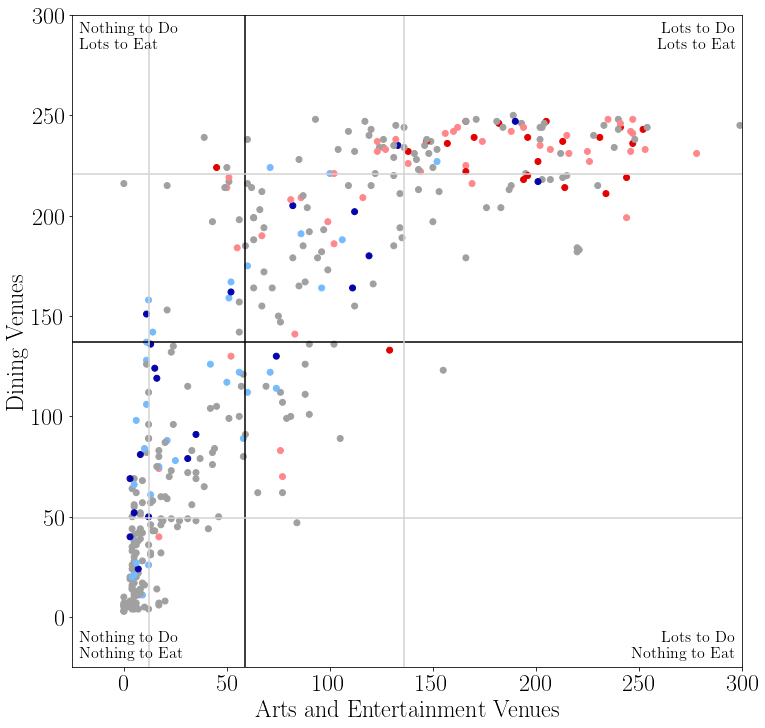

In [11]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.scatter(
    df_final_data['Arts And Entertainment'],
    df_final_data['Food'],
    color = df_final_data['Map_Color']
)
ax.axvline(median_arts[1],color='black')
ax.axhline(median_food[1],color='black')
ax.axvline(median_arts[0],color='lightgray')
ax.axhline(median_food[0],color='lightgray')
ax.axvline(median_arts[2],color='lightgray')
ax.axhline(median_food[2],color='lightgray')
ax.set_xlabel('Arts and Entertainment Venues')
ax.set_ylabel('Dining Venues')
ax.text(0.99,0.99,'Lots to Do\nLots to Eat',transform=ax.transAxes,ha='right',va='top', size=16)
ax.text(0.99,0.01,'Lots to Do\nNothing to Eat',transform=ax.transAxes,ha='right',va='bottom', size=16)
ax.text(0.01,0.99,'Nothing to Do\nLots to Eat',transform=ax.transAxes,ha='left',va='top', size=16)
ax.text(0.01,0.01,'Nothing to Do\nNothing to Eat',transform=ax.transAxes,ha='left',va='bottom', size=16)
ax.set_xlim([-25,300])
ax.set_ylim([-25,300])
plt.show()

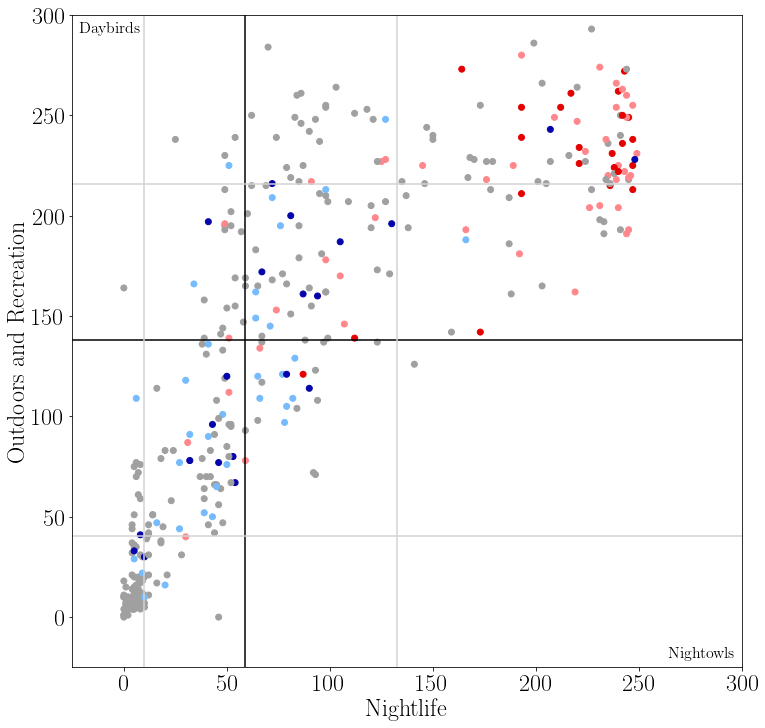

In [12]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.scatter(
    df_final_data['Nightlife'],
    df_final_data['Outdoors And Recreation'],
    color = df_final_data['Map_Color']
)
ax.axvline(median_night[1],color='black')
ax.axhline(median_outdoors[1],color='black')
ax.axvline(median_night[0],color='lightgray')
ax.axhline(median_outdoors[0],color='lightgray')
ax.axvline(median_night[2],color='lightgray')
ax.axhline(median_outdoors[2],color='lightgray')
ax.set_xlabel('Nightlife')
ax.set_ylabel('Outdoors and Recreation')
ax.text(0.99,0.99,'',transform=ax.transAxes,ha='right',va='top', size=16)
ax.text(0.99,0.01,'Nightowls',transform=ax.transAxes,ha='right',va='bottom', size=16)
ax.text(0.01,0.99,'Daybirds',transform=ax.transAxes,ha='left',va='top', size=16)
ax.text(0.01,0.01,'',transform=ax.transAxes,ha='left',va='bottom', size=16)
ax.set_xlim([-25,300])
ax.set_ylim([-25,300])
plt.show()

Looking at just the previous two figures, Summer Olympic cities tend to have more of everything when it comes to venues. This makes sense. Typically in warmer weather, people tend to want to do more activities and these cities provide for them. Winter Olympic cities on the other hand, don't need to have as many venues. In fact, just from the population data alone, Winter cities tend to have fewer people. I suspect that a primary driver for this is the amount to space needed along with the terrain required. Typically, you'd want more open areas to build larger structures such as ski slopes, etc. Summer Olympics primarily just needs a track and field and swimming pool. Admittedly, these are not per capita numbers which is something we can look at but this does leave out many winter cities which have populations that didn't meet the UN population cutoff. But we'll check it anyway. I suspect that this will skew towards the lower populations cities since venue count does not scale linearly with population.

In [96]:
# Per capita data
df_per_capita_venues=df_final_data[df_final_data['Population']>0]
df_per_capita_venues['Arts And Entertainment']=df_per_capita_venues['Arts And Entertainment'].divide(df_per_capita_venues['Population'])*1000000
df_per_capita_venues['Food']=df_per_capita_venues['Food'].divide(df_per_capita_venues['Population'])*1000000
df_per_capita_venues['Nightlife']=df_per_capita_venues['Nightlife'].divide(df_per_capita_venues['Population'])*1000000
df_per_capita_venues['Outdoors And Recreation']=df_per_capita_venues['Outdoors And Recreation'].divide(df_per_capita_venues['Population'])*1000000
df_per_capita_venues.sample(10)

,Country,City,Capital,Population,Winter,Summer,Year,Latitude,Longitude,Arts And Entertainment,Food,Nightlife,Outdoors And Recreation,Map_Color
189,Japan,Sapporo,0,1952356,2,0,2026,43.061936,141.354292,97.318317,126.513812,36.878520,110.635560,#0504aa
106,India,Allahabad,0,1168385,0,0,0,25.438130,81.833800,17.117645,6.847058,4.279411,3.423529,#A0A0A0
285,South Korea,Seoul,1,9776305,0,2,1988,37.566679,126.978291,25.776610,24.856017,24.140000,21.991949,#e50000
280,South Korea,Daegu,0,2465268,0,0,0,35.871300,128.601800,18.659229,20.281771,2.839448,24.743760,#A0A0A0
203,Mexico,Juárez,0,1462133,0,0,0,19.293483,-100.464592,2.051797,12.994714,2.735729,9.575052,#A0A0A0
5,Argentina,Buenos Aires,1,13879707,0,1,2004,-34.607568,-58.437089,14.913859,16.787098,15.850479,17.795765,#ff878c
117,India,Gwalior,0,1054420,0,0,0,26.203725,78.157363,11.380664,3.793555,1.896777,4.741943,#A0A0A0
126,India,Kolkata,0,4496694,0,0,0,22.545412,88.356775,7.783496,15.344607,10.007352,14.677450,#A0A0A0
29,Brazil,Belém,0,1446042,0,0,0,-1.450560,-48.468245,75.378170,148.681712,75.378170,143.149369,#A0A0A0
77,Finland,Tampere,0,230064,1,0,1976,61.498021,23.760312,308.609778,530.287224,330.342861,847.590236,#75bbfd


In [97]:
median_arts = (df_per_capita_venues['Arts And Entertainment'].quantile(0.25),df_per_capita_venues['Arts And Entertainment'].median(),df_per_capita_venues['Arts And Entertainment'].quantile(0.75))
median_food = (df_per_capita_venues['Food'].quantile(0.25),df_per_capita_venues['Food'].median(),df_per_capita_venues['Food'].quantile(0.75))
median_night = (df_per_capita_venues['Nightlife'].quantile(0.25),df_per_capita_venues['Nightlife'].median(),df_per_capita_venues['Nightlife'].quantile(0.75))
median_outdoors = (df_per_capita_venues['Outdoors And Recreation'].quantile(0.25),df_per_capita_venues['Outdoors And Recreation'].median(),df_per_capita_venues['Outdoors And Recreation'].quantile(0.75))
df_per_capita_venues.describe()

,Capital,Population,Winter,Summer,Year,Latitude,Longitude,Arts And Entertainment,Food,Nightlife,Outdoors And Recreation
count,352.000000,3.520000e+02,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000
mean,0.255682,2.456131e+06,0.125000,0.258523,521.508523,25.069262,25.202417,65.439051,133.411813,77.784342,120.117685
std,0.436865,2.800044e+06,0.428673,0.568585,878.081157,22.581624,70.004932,89.130620,402.946938,158.620871,275.984686
min,0.000000,2.220500e+04,0.000000,0.000000,0.000000,-37.814218,-123.113953,0.000000,1.123596,0.000000,0.000000
25%,0.000000,1.107036e+06,0.000000,0.000000,0.000000,13.728711,-6.832321,7.382107,22.165748,5.947453,15.944922
50%,0.000000,1.516634e+06,0.000000,0.000000,0.000000,31.493832,35.526523,32.726839,63.935477,34.443341,65.068833
75%,1.000000,2.526165e+06,0.000000,0.000000,1936.000000,40.230914,75.901308,89.092607,146.676039,82.845146,142.743620
max,1.000000,2.180032e+07,2.000000,2.000000,2028.000000,61.498021,174.763180,578.082418,7115.514524,2161.675298,4548.525107


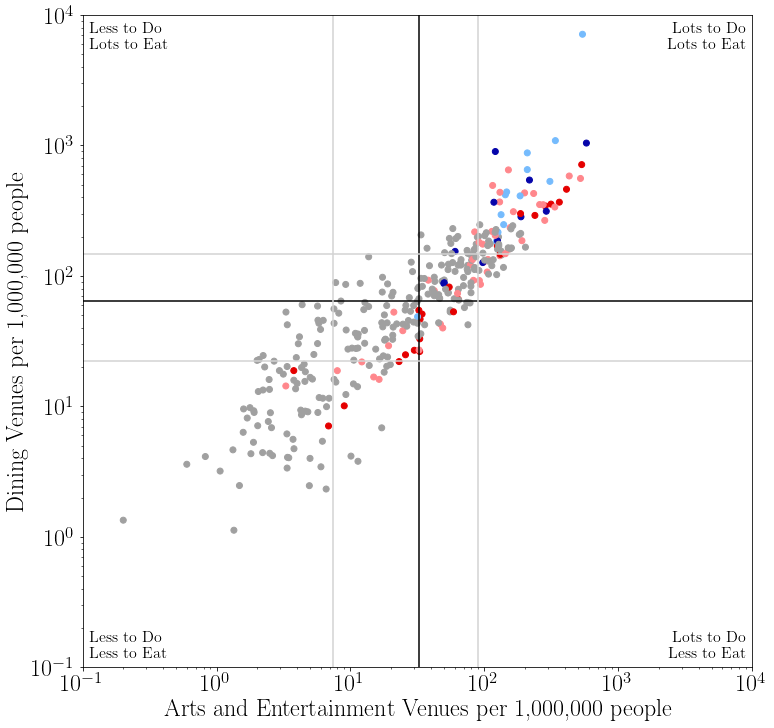

In [98]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.scatter(
    df_per_capita_venues['Arts And Entertainment'],
    df_per_capita_venues['Food'],
    color = df_per_capita_venues['Map_Color']
)
ax.axvline(median_arts[1],color='black')
ax.axhline(median_food[1],color='black')
ax.axvline(median_arts[0],color='lightgray')
ax.axhline(median_food[0],color='lightgray')
ax.axvline(median_arts[2],color='lightgray')
ax.axhline(median_food[2],color='lightgray')
ax.set_xlabel('Arts and Entertainment Venues per 1,000,000 people')
ax.set_ylabel('Dining Venues per 1,000,000 people')
ax.text(0.99,0.99,'Lots to Do\nLots to Eat',transform=ax.transAxes,ha='right',va='top', size=16)
ax.text(0.99,0.01,'Lots to Do\nLess to Eat',transform=ax.transAxes,ha='right',va='bottom', size=16)
ax.text(0.01,0.99,'Less to Do\nLots to Eat',transform=ax.transAxes,ha='left',va='top', size=16)
ax.text(0.01,0.01,'Less to Do\nLess to Eat',transform=ax.transAxes,ha='left',va='bottom', size=16)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([0.1,10000])
ax.set_ylim([0.1,10000])
plt.show()

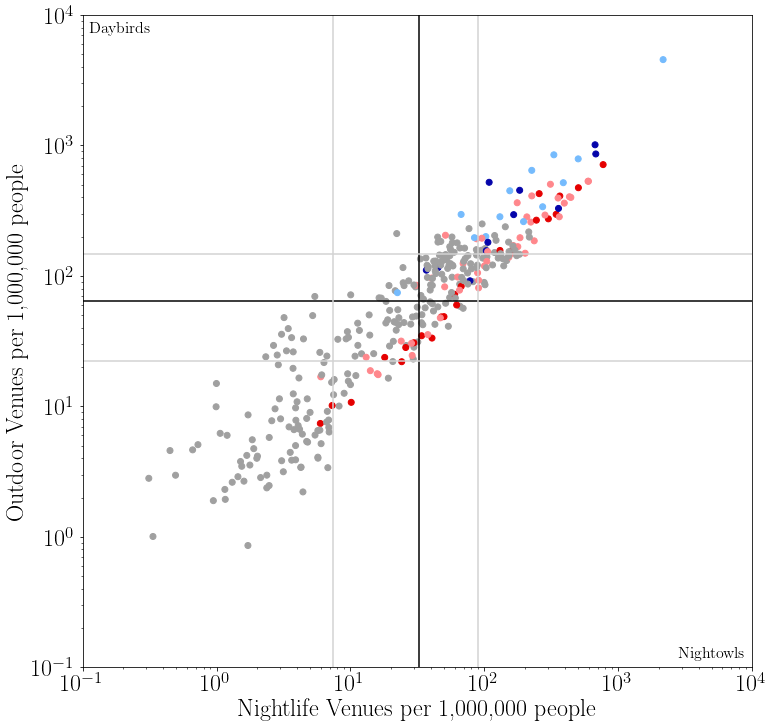

In [99]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.scatter(
    df_per_capita_venues['Nightlife'],
    df_per_capita_venues['Outdoors And Recreation'],
    color = df_per_capita_venues['Map_Color']
)
ax.axvline(median_arts[1],color='black')
ax.axhline(median_food[1],color='black')
ax.axvline(median_arts[0],color='lightgray')
ax.axhline(median_food[0],color='lightgray')
ax.axvline(median_arts[2],color='lightgray')
ax.axhline(median_food[2],color='lightgray')
ax.set_xlabel('Nightlife Venues per 1,000,000 people')
ax.set_ylabel('Outdoor Venues per 1,000,000 people')
ax.text(0.99,0.99,'',transform=ax.transAxes,ha='right',va='top', size=16)
ax.text(0.99,0.01,'Nightowls',transform=ax.transAxes,ha='right',va='bottom', size=16)
ax.text(0.01,0.99,'Daybirds',transform=ax.transAxes,ha='left',va='top', size=16)
ax.text(0.01,0.01,'',transform=ax.transAxes,ha='left',va='bottom', size=16)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([0.1,10000])
ax.set_ylim([0.1,10000])
plt.show()

Looking at the per capita data, the Olympic cities are generally well clustered in the upper right quadrant of each figure. The far upper right outlier is Andorra which only has a population of ~20,000 people but many venues. We can also see that Winter cities tend to have more outdoor activities than Summer cities.

In [100]:
# set number of clusters
kclusters = 6
city_clustering = df_per_capita_venues.drop(['Country','City','Capital','Population','Winter','Summer','Year','Latitude','Longitude','Map_Color'], 1)
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(city_clustering)
# add clustering labels
df_per_capita_venues.insert(2,'Cluster Labels', kmeans.labels_)
df_per_capita_venues.sample(10) # check the last columns!

,Country,City,Cluster Labels,Capital,Population,Winter,Summer,Year,Latitude,Longitude,Arts And Entertainment,Food,Nightlife,Outdoors And Recreation,Map_Color
310,Thailand,Bangkok,3,1,8305218,0,1,2008,13.753893,100.816080,19.264997,29.138308,28.897496,24.562871,#ff878c
190,Japan,Sendai,0,0,1082159,0,0,0,38.267755,140.869150,158.017445,229.171499,57.292875,198.676904,#A0A0A0
356,United States of America,Colorado Springs Co,2,0,465101,1,0,1956,38.833958,-104.825349,184.906074,410.663490,154.805085,449.364762,#75bbfd
18,Austria,Salzburg,4,0,153377,1,0,2014,47.798135,13.046481,339.033884,1088.820358,502.030943,788.905768,#75bbfd
367,United States of America,Phoenix Az,0,0,1615017,0,0,0,33.448437,-112.074142,116.407443,133.125534,144.890116,134.983099,#A0A0A0
61,Colombia,Bogotá D.C.,3,1,8181047,0,0,0,4.615571,-74.068470,16.501555,23.102178,12.101141,25.302385,#A0A0A0
165,Iran,Karaj,3,0,1592492,0,0,0,35.822896,50.958764,7.535360,55.887251,10.047146,71.585917,#A0A0A0
65,Cuba,Havana,3,1,2130517,0,1,2012,23.135305,-82.358963,7.979284,18.774786,14.081089,18.774786,#ff878c
361,United States of America,Houston Tx,0,0,2303482,0,0,0,29.758938,-95.367697,79.444945,88.561578,101.151214,85.522700,#A0A0A0
189,Japan,Sapporo,0,0,1952356,2,0,2026,43.061936,141.354292,97.318317,126.513812,36.878520,110.635560,#0504aa


In [105]:
cluster_colors = ["#7e1e9c","#15b01a","#f97306","#dbb40c","#7f4e1e","#b9a281"]
df_per_capita_venues['Cluster_Color']=(df_per_capita_venues['Cluster Labels'].replace({0:cluster_colors[0],1:cluster_colors[1],2:cluster_colors[2],3:cluster_colors[3],4:cluster_colors[4],5:cluster_colors[5]}))

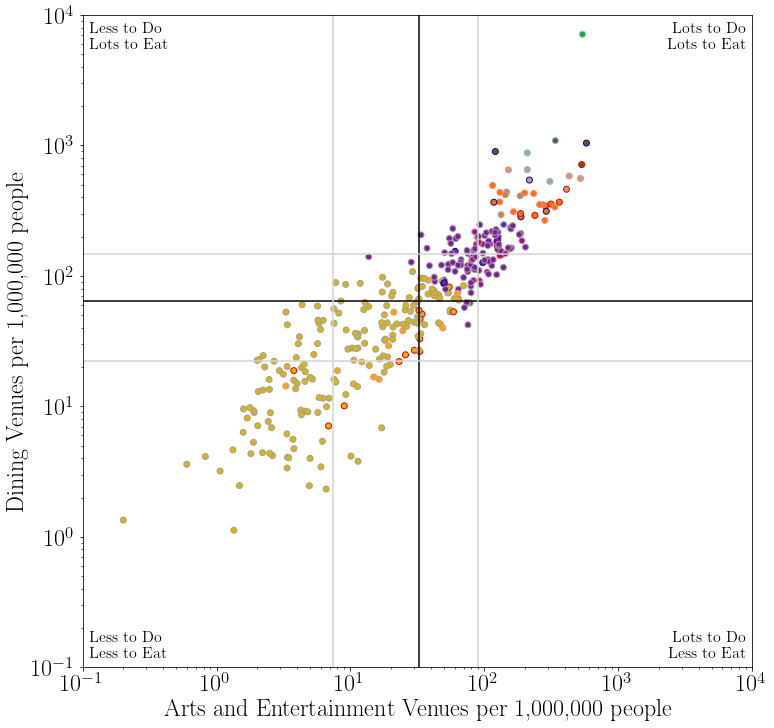

In [106]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.scatter(
    df_per_capita_venues['Arts And Entertainment'],
    df_per_capita_venues['Food'],
    edgecolor = df_per_capita_venues['Map_Color'],
    color=df_per_capita_venues['Cluster_Color']
)
ax.axvline(median_arts[1],color='black')
ax.axhline(median_food[1],color='black')
ax.axvline(median_arts[0],color='lightgray')
ax.axhline(median_food[0],color='lightgray')
ax.axvline(median_arts[2],color='lightgray')
ax.axhline(median_food[2],color='lightgray')
ax.set_xlabel('Arts and Entertainment Venues per 1,000,000 people')
ax.set_ylabel('Dining Venues per 1,000,000 people')
ax.text(0.99,0.99,'Lots to Do\nLots to Eat',transform=ax.transAxes,ha='right',va='top', size=16)
ax.text(0.99,0.01,'Lots to Do\nLess to Eat',transform=ax.transAxes,ha='right',va='bottom', size=16)
ax.text(0.01,0.99,'Less to Do\nLots to Eat',transform=ax.transAxes,ha='left',va='top', size=16)
ax.text(0.01,0.01,'Less to Do\nLess to Eat',transform=ax.transAxes,ha='left',va='bottom', size=16)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([0.1,10000])
ax.set_ylim([0.1,10000])
plt.show()

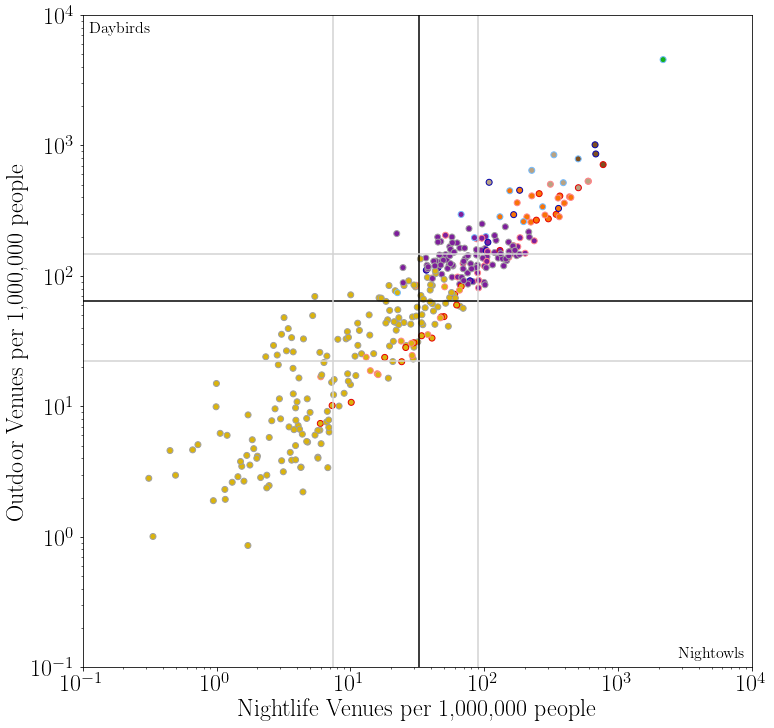

In [107]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.scatter(
    df_per_capita_venues['Nightlife'],
    df_per_capita_venues['Outdoors And Recreation'],
    edgecolor = df_per_capita_venues['Map_Color'],
    color=df_per_capita_venues['Cluster_Color']
)
ax.axvline(median_arts[1],color='black')
ax.axhline(median_food[1],color='black')
ax.axvline(median_arts[0],color='lightgray')
ax.axhline(median_food[0],color='lightgray')
ax.axvline(median_arts[2],color='lightgray')
ax.axhline(median_food[2],color='lightgray')
ax.set_xlabel('Nightlife Venues per 1,000,000 people')
ax.set_ylabel('Outdoor Venues per 1,000,000 people')
ax.text(0.99,0.99,'',transform=ax.transAxes,ha='right',va='top', size=16)
ax.text(0.99,0.01,'Nightowls',transform=ax.transAxes,ha='right',va='bottom', size=16)
ax.text(0.01,0.99,'Daybirds',transform=ax.transAxes,ha='left',va='top', size=16)
ax.text(0.01,0.01,'',transform=ax.transAxes,ha='left',va='bottom', size=16)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([0.1,10000])
ax.set_ylim([0.1,10000])
plt.show()

In [108]:
olympic_viability = []
for cluster in range(kclusters):
    df_cluster=df_per_capita_venues[df_per_capita_venues['Cluster Labels'] == cluster]
    olympic_viability.append((df_cluster['Winter']+df_cluster['Summer']).mean())
print(olympic_viability)

[0.34545454545454546, 1.0, 1.4545454545454546, 0.2222222222222222, 1.75, 1.375]


In [112]:
cluster = 2
df_per_capita_venues[df_per_capita_venues['Cluster Labels'] == cluster]

,Country,City,Cluster Labels,Capital,Population,Winter,Summer,Year,Latitude,Longitude,Arts And Entertainment,Food,Nightlife,Outdoors And Recreation,Map_Color,Cluster_Color
15,Austria,Graz,2,0,286292,1,0,2026,47.070868,15.438279,146.703366,440.110097,272.449108,338.814916,#75bbfd,#f97306
24,Belgium,Antwerp,2,0,718730,0,2,1920,51.221110,4.399708,285.225328,343.661737,343.661737,296.356073,#e50000,#f97306
75,Finland,Helsinki,2,1,639227,1,2,2006,60.167410,24.942577,314.442287,355.116414,256.559876,427.078331,#e50000,#f97306
90,Germany,Frankfurt,2,0,746878,0,1,1936,50.110644,8.682092,164.685531,310.626367,222.258521,258.409004,#ff878c,#f97306
96,Germany,Nuremberg,2,0,515201,0,1,1936,49.453872,11.077298,130.046331,368.788104,207.685932,283.384543,#ff878c,#f97306
99,Greece,Athens,2,1,664046,0,2,2004,37.983941,23.728305,362.926665,367.444424,365.938504,409.610178,#e50000,#f97306
173,Ireland,Dublin,2,1,544107,0,1,1936,53.349764,-6.260273,233.409973,428.224596,431.900343,404.332236,#ff878c,#f97306
225,Netherlands,Amsterdam,2,1,821752,0,2,1992,52.372760,4.893604,238.514783,290.842006,300.577303,273.805236,#e50000,#f97306
230,Norway,Oslo,2,1,634293,2,0,2022,59.913330,10.738970,187.610458,283.780524,165.538639,294.816433,#0504aa,#f97306
264,Russia,Sochi,2,0,441407,2,0,2014,43.585482,39.723109,117.805110,367.008226,183.504113,453.096575,#0504aa,#f97306


In [ ]:
df_per_capita_venues.to_csv('clustered_data_per_capita.csv')